In [2]:
from matplotlib import pyplot as plt
from itertools import product
import seaborn as sns
import numpy as np
import pandas as pd
import os.path as op
import argparse
import re
from sklearn.linear_model import LinearRegression

In [33]:
# Load task accuracies
accuracies = pd.read_csv('accuracies.csv')
behav_subs = np.unique(accuracies.sub_num)
accuracies

,sub_num,accuracy
0,1,0.952563
1,2,0.901232
2,3,0.785415
3,4,0.958154
4,5,0.919971
5,6,0.921653
6,7,0.911613
7,8,0.989489
8,9,0.912759
9,10,0.965335


In [40]:
# Load power
spectrums = pd.read_csv('spectrums.csv', sep = '\t')
spectrums = spectrums[spectrums.subject.isin(behav_subs)] # Drop subs not in behavioral data
spec_subs = np.unique(spectrums.subject)
accuracies = accuracies[accuracies.sub_num.isin(spec_subs)] # Drop subs not in power

In [59]:
# Run ANOVA
targets = (130, 200, 280)
target_freqs = (130, 200, 280)
power = []

for target, target_freq in zip(targets, target_freqs):
    print(target, target_freq)
    
    idx = np.abs(spectrums.frequency - target_freq).argmin()
    hz = spectrums.frequency[idx]
    idx = np.abs(spectrums.frequency - target_freq*2).argmin()
    hz_harmonic1 = spectrums.frequency[idx]
    power_f0 = spectrums[(spectrums.frequency == hz) | (spectrums.frequency == hz_harmonic1)]
    power_f0 = power_f0[power_f0.stimulus == target]
    power_f0 = power_f0.groupby(['subject', 'target', 'stimulus'], as_index=False).mean()

    power.append(power_f0)
power = pd.concat(power)

130 130
200 200
280 280


In [73]:
# Add accuracy scores to power
power['accuracy'] = [val for val in accuracies.accuracy for _ in range(3)]*3
power

,subject,target,stimulus,frequency,power,accuracy
0,3,130,130,194.190871,4.499763,0.785415
1,3,200,130,194.190871,7.971883,0.785415
2,3,280,130,194.190871,7.028215,0.785415
3,4,130,130,194.190871,0.440029,0.958154
4,4,200,130,194.190871,1.040998,0.958154
...,...,...,...,...,...,...
79,30,200,280,418.257261,5.645911,0.975812
80,30,280,280,418.257261,7.555284,0.975812
81,31,130,280,418.257261,2.954490,0.939970
82,31,200,280,418.257261,2.848199,0.939970


## Plots

<AxesSubplot:xlabel='accuracy', ylabel='power'>

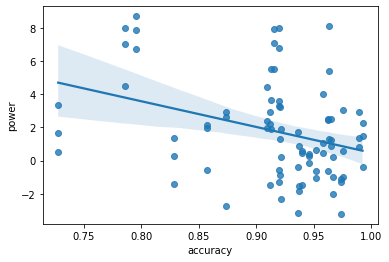

In [82]:
power_130 = power[power.stimulus == 130]
sns.regplot(data = power_130, x="accuracy", y="power")
# reg = LinearRegression().fit(power_130.accuracy, power_130.power)

<AxesSubplot:xlabel='accuracy', ylabel='power'>

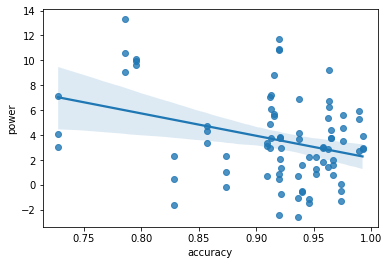

In [78]:
power_200 = power[power.stimulus == 200]
sns.regplot(data = power_200, x="accuracy", y="power")

<AxesSubplot:xlabel='accuracy', ylabel='power'>

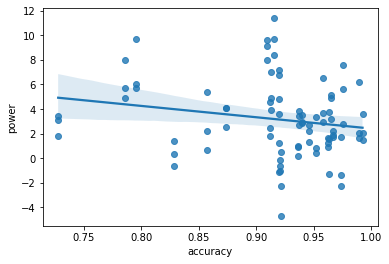

In [83]:
power_280 = power[power.stimulus == 280]
sns.regplot(data = power_280, x="accuracy", y="power")

In [69]:
len(np.unique(accuracies.sub_num))

28

In [72]:
84*3

252